In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


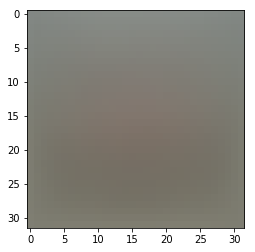

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [6]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.891949


In [7]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -44.270714 analytic: -1878.698367, relative error: 9.539559e-01
numerical: 1.296459 analytic: 998.447857, relative error: 9.974064e-01
numerical: 13.255846 analytic: 1339.821429, relative error: 9.804064e-01
numerical: 16.850712 analytic: 3139.786429, relative error: 9.893236e-01
numerical: 17.311882 analytic: 1605.064286, relative error: 9.786586e-01
numerical: 26.379990 analytic: 3699.037551, relative error: 9.858378e-01
numerical: -15.913318 analytic: 358.987102, relative error: 1.000000e+00
numerical: -3.035856 analytic: 1939.482857, relative error: 1.000000e+00
numerical: -28.595647 analytic: -4418.735714, relative error: 9.871403e-01
numerical: 9.231850 analytic: 1137.123306, relative error: 9.838936e-01
numerical: 1.385628 analytic: -545.943224, relative error: 1.000000e+00
numerical: 9.330690 analytic: 2222.446939, relative error: 9.916383e-01
numerical: 10.436524 analytic: 3520.799286, relative error: 9.940890e-01
numerical: -12.175809 analytic: -823.368531, relativ

In [8]:
X_dev.shape

(500, 3073)

In [9]:
X_dev[0].shape

(3073,)

In [10]:
W.shape

(3073, 10)

In [11]:
num_classes = W.shape[1]
num_train = X_dev.shape[0]
num_classes, num_train

(10, 500)

In [12]:
dW = np.zeros(W.shape)
dW.shape

(3073, 10)

In [13]:
dW[:, 0].shape

(3073,)

In [14]:
dW

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
X_dev[0]

array([ -5.64189796, -10.98173469,  -9.47391837, ...,  86.13804082,
       116.60042857,   1.        ])

In [16]:
dW[:, 0] += -X_dev[0]
dW

array([[   5.64189796,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  10.98173469,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   9.47391837,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [ -86.13804082,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [-116.60042857,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  -1.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [17]:
dW[:, 1] += -X_dev[0]
dW

array([[   5.64189796,    5.64189796,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  10.98173469,   10.98173469,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   9.47391837,    9.47391837,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [ -86.13804082,  -86.13804082,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [-116.60042857, -116.60042857,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  -1.        ,   -1.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [18]:
X_dev[0].shape

(3073,)

In [19]:
y_dev.shape

(500,)

In [20]:
W = np.random.randn(3073, 10) * 0.0001 
scores = X_dev[0].dot(W)

In [21]:
scores

array([ 0.22268451, -0.68128923,  0.45071327,  0.07100069,  0.06798618,
        0.45259237, -0.04874416,  0.45544872, -0.25331415, -0.60950301])

In [22]:
margins = np.maximum(0, scores - scores[1])

In [23]:
margins

array([0.90397374, 0.        , 1.13200249, 0.75228992, 0.74927541,
       1.1338816 , 0.63254507, 1.13673795, 0.42797508, 0.07178622])

In [24]:
scores_all = X_dev.dot(W)

In [25]:
scores_all

array([[ 0.22268451, -0.68128923,  0.45071327, ...,  0.45544872,
        -0.25331415, -0.60950301],
       [ 0.61706836,  0.63265063, -0.13387155, ...,  0.17687463,
        -0.31758215,  0.03717569],
       [-0.19083959, -0.4817719 , -0.3885284 , ..., -0.68713516,
         0.13478828,  0.45241036],
       ...,
       [ 0.14536011,  0.52675305,  0.01212998, ..., -0.01548239,
        -0.18584947,  0.55481953],
       [ 0.23592399, -0.09311642, -0.06879388, ..., -0.14739337,
        -0.15213442,  0.16752011],
       [ 0.05282976, -0.14893506,  0.45670419, ...,  0.14467765,
        -0.26678343,  0.09022712]])

In [26]:
scores_all.shape

(500, 10)

In [27]:
slices = y_dev.reshape(y_dev.shape[0],1)

In [28]:
true_scores = np.take_along_axis(scores_all, slices, axis=1)
true_scores

array([[ 0.45259237],
       [ 0.61706836],
       [-0.3885284 ],
       [-0.35713447],
       [-0.0972917 ],
       [-0.20303681],
       [ 0.09308603],
       [ 0.29218803],
       [-0.12216397],
       [ 0.28401803],
       [ 0.04678927],
       [ 0.12002111],
       [ 0.05326173],
       [ 0.07287495],
       [-0.37891847],
       [-0.08937257],
       [ 0.23215259],
       [-0.3167266 ],
       [ 0.08358449],
       [ 0.26414463],
       [-0.2143047 ],
       [ 0.12016616],
       [-0.09762017],
       [-0.00918901],
       [-0.78174211],
       [ 0.38809215],
       [-0.2103599 ],
       [-0.09704199],
       [ 0.07146379],
       [ 0.33542308],
       [ 0.28843536],
       [-0.03776745],
       [ 0.19970353],
       [-0.34451022],
       [ 0.08952456],
       [-0.95787702],
       [-0.03542579],
       [ 0.13180664],
       [-0.02823774],
       [-0.22827969],
       [-0.19616572],
       [-0.15653635],
       [ 0.548517  ],
       [-0.26352123],
       [-0.04312724],
       [ 0

In [40]:
margins = np.maximum(0, scores_all - true_scores + 1)

In [41]:
margins

array([[0.77009214, 0.        , 0.9981209 , ..., 1.00285636, 0.29409348,
        0.        ],
       [1.        , 1.01558227, 0.24906009, ..., 0.55980627, 0.06534949,
        0.42010733],
       [1.1976888 , 0.9067565 , 1.        , ..., 0.70139323, 1.52331668,
        1.84093875],
       ...,
       [1.33120957, 1.71260251, 1.19797944, ..., 1.17036708, 1.        ,
        1.740669  ],
       [1.        , 0.67095959, 0.69528213, ..., 0.61668264, 0.61194159,
        0.93159612],
       [1.22373965, 1.02197483, 1.62761409, ..., 1.31558754, 0.90412647,
        1.26113702]])

In [42]:
np.put_along_axis(margins, slices, 0, axis=1)
margins

array([[0.77009214, 0.        , 0.9981209 , ..., 1.00285636, 0.29409348,
        0.        ],
       [0.        , 1.01558227, 0.24906009, ..., 0.55980627, 0.06534949,
        0.42010733],
       [1.1976888 , 0.9067565 , 0.        , ..., 0.70139323, 1.52331668,
        1.84093875],
       ...,
       [1.33120957, 1.71260251, 1.19797944, ..., 1.17036708, 0.        ,
        1.740669  ],
       [0.        , 0.67095959, 0.69528213, ..., 0.61668264, 0.61194159,
        0.93159612],
       [1.22373965, 1.02197483, 1.62761409, ..., 1.31558754, 0.90412647,
        1.26113702]])

In [44]:
np.sum(margins)

4355.773326538197